# Import Libraries

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=94a53763975ef3ffd68a789989997b051055d68881c6a7c97bc357ee16e64a6d
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [26]:
import seaborn as sns # Library for statistical data visualization
import matplotlib.pyplot as plt # Plotting library

from pyspark.sql import SparkSession # Entry point to Spark SQL functionality
from pyspark.sql.functions import col # Function for operating on columns in DataFrame
from pyspark.ml.feature import VectorAssembler, StandardScaler # Tools for feature engineering
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier # ML classifiers
from pyspark.ml import Pipeline # Tools for constructing ML pipelines
from pyspark.ml.evaluation import BinaryClassificationEvaluator # Evaluator for binary classification models

# Initialize Spark Session

In [27]:
# SparkSession is the entry point to Spark SQL, allowing interaction with Spark functionality
spark = SparkSession.builder \
    .appName("CreditCardFraudDetection") \
    .getOrCreate()

# Loading the Dataset

In [28]:
# Kaggle dataset link: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

# Load the dataset
df = spark.read.csv("creditcard.csv", header=True, inferSchema=True)

# Display the first few rows of the dataset
df.show(5)

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|                V22|     

In [29]:
# Display statistical information
df.describe().show()

+-------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|summary|              Time|                  V1|                  V2|                  V3|                  V4|                  V5|                  V6|                  V7|                  V8|                  V9|                 V10|                 V11|                 V12|                 V13|                 V14|                 V15|

In [30]:
# Display datatype information
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

# Preprocessing

In [31]:
# Sum of null values for all columns
df.selectExpr([f"sum(case when {col} is null then 1 else 0 end) as {col}" for col in df.columns]).show()

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



# Exploratory Data Analysis

<Axes: ylabel='Count'>

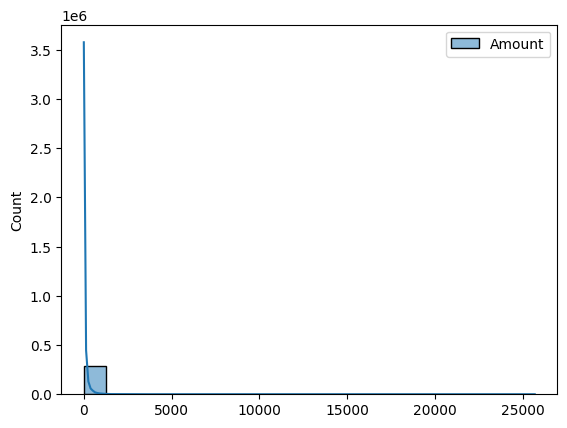

In [32]:
# Display distribution of Amount
amount_counts = df.select("Amount").toPandas()
sns.histplot(amount_counts, bins=20, kde=True)

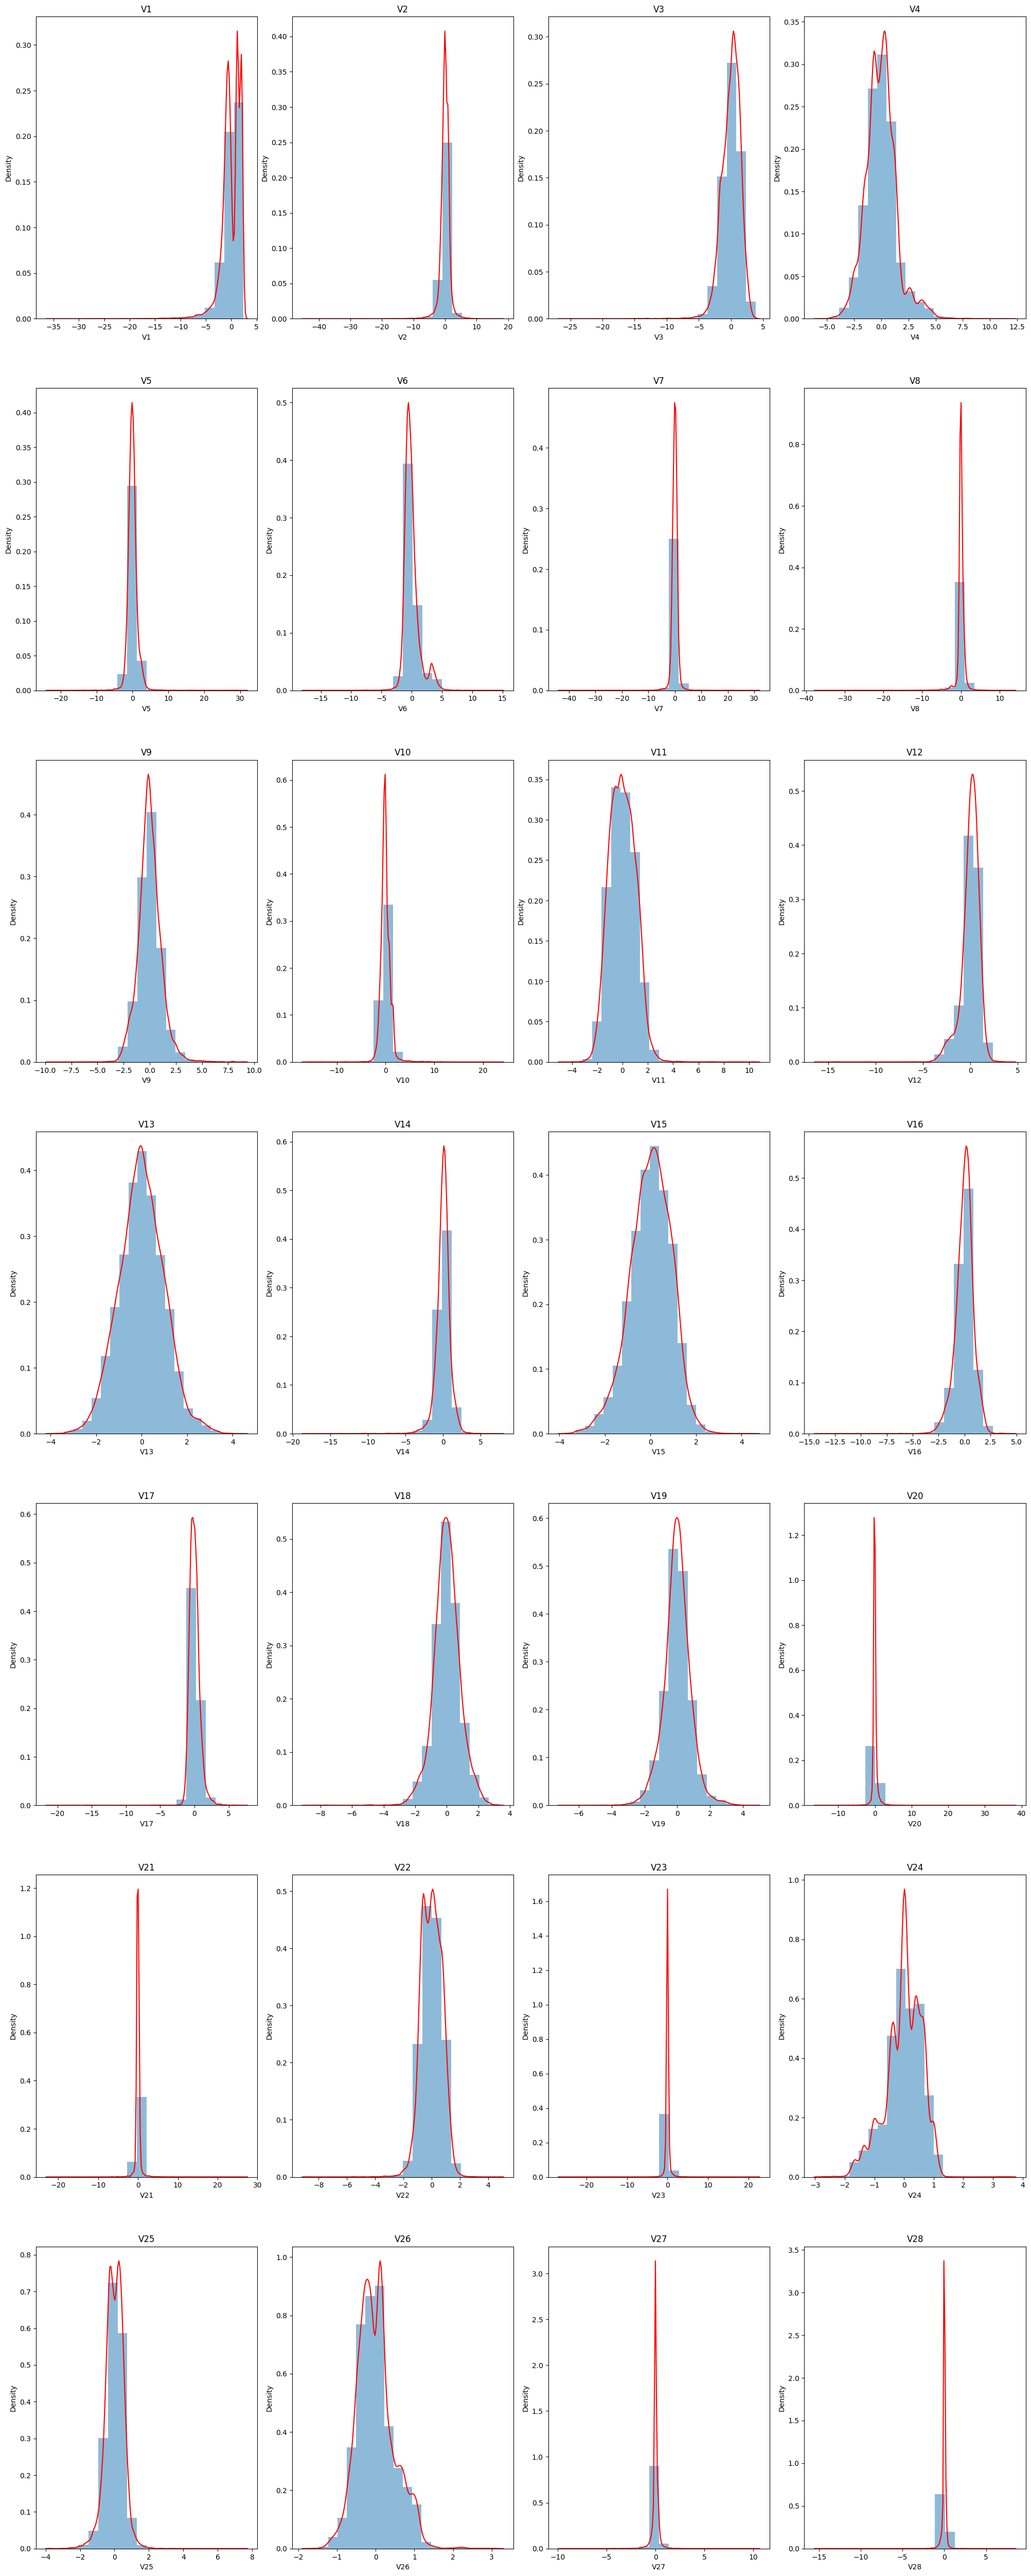

In [33]:
# Display distribution of transformed features obtained through PCA transformation

# Drop columns Time, Amount, and Class
df_temp = df.drop("Time", "Amount", "Class")

# Define number of rows and columns for subplots
num_cols = 4
num_rows = 7

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 50))

# Flatten axes
axs = axs.flatten()

# Loop through columns and plot distribution using PySpark sample() and Matplotlib
for i, col in enumerate(df_temp.columns):
    ax = axs[i]
    data = df.select(col).sample(False, 0.1).toPandas()
    ax.hist(data, bins=20, density=True, histtype='stepfilled', alpha=0.5)
    sns.kdeplot(data[col], ax=ax, color='r')
    ax.set_title(col)

# Hide empty subplots
for i in range(len(df_temp.columns), num_rows * num_cols):
    fig.delaxes(axs[i])

plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5)
plt.show()

# Correlation Matrix

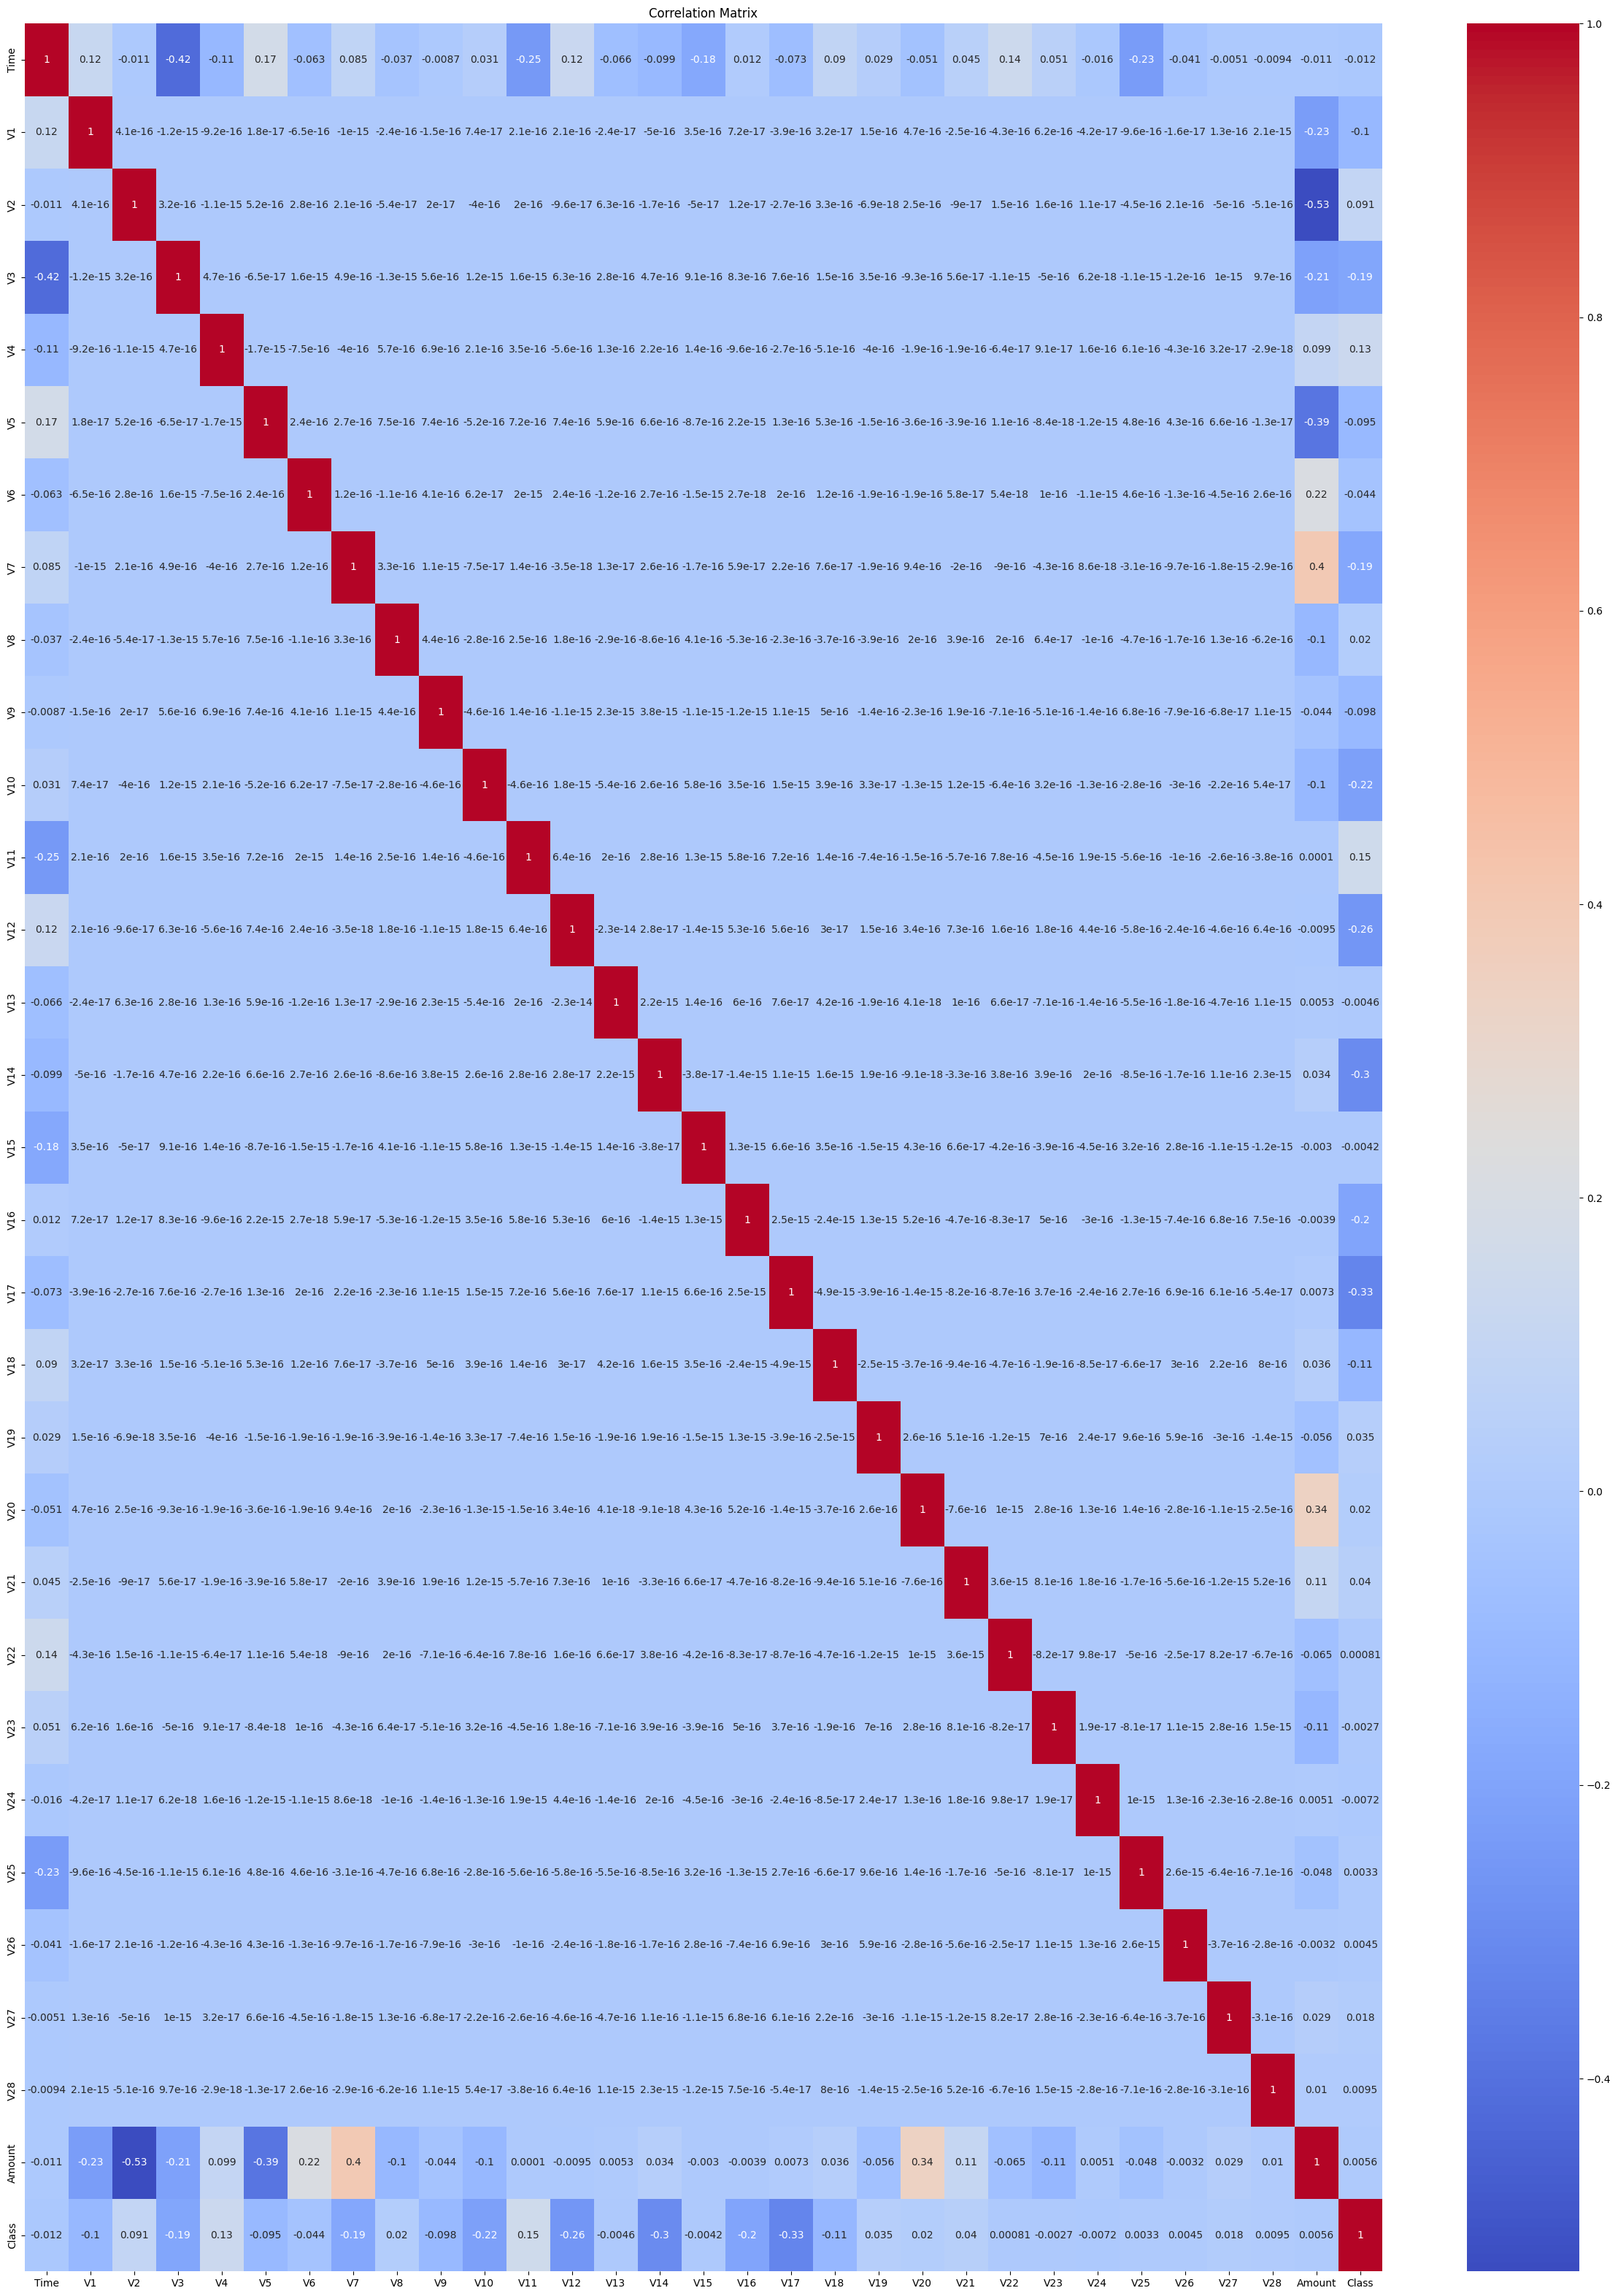

In [34]:
# Correlation matrix provides insights into the relationships between variables, helping to identify patterns

# Compute correlation matrix
corr = df.toPandas().corr()

# Plot correlation matrix
plt.figure(figsize=(30, 40))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")

plt.savefig('/content/correlation_matrix.png')

plt.show()

# Input Split

In [35]:
# Input Split
X = df.drop("Class")
y = df.select("Class")

# VectorAssembler

In [36]:
# Combines input columns into a single vector column
assembler = VectorAssembler(inputCols=[col for col in df.columns if col != "Class"], outputCol="features")

# Standard Scaling

In [37]:
# Makes sure all features have similar scales for better model performance
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Model Training and Testing

In [38]:
# Splitting the data into training and testing sets
(train_data, test_data) = df.randomSplit([0.80, 0.20], seed=42)

In [39]:
# Pipelines are used to chain multiple stages together, enabling easy reuse and management of ML workflows

# Decision Tree Pipeline
# Decision Tree is a supervised learning algorithm used for classification and regression tasks
dt = DecisionTreeClassifier(featuresCol="scaledFeatures", labelCol="Class")
dt_pipeline = Pipeline(stages=[assembler, scaler, dt])
dt_model = dt_pipeline.fit(train_data)
dt_predictions = dt_model.transform(test_data)

# Random Forest Pipeline
# Random Forest is an ensemble learning method that constructs multiple decision trees during training
rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="Class", numTrees=100)
rf_pipeline = Pipeline(stages=[assembler, scaler, rf])
rf_model = rf_pipeline.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# XGBoost Pipeline
# XGBoost is an optimized distributed gradient boosting library designed for efficient and flexible ML modeling
xgb = GBTClassifier(featuresCol="scaledFeatures", labelCol="Class", maxIter=100)
xgb_pipeline = Pipeline(stages=[assembler, scaler, xgb])
xgb_model = xgb_pipeline.fit(train_data)
xgb_predictions = xgb_model.transform(test_data)

# Evaluation

In [40]:
# Binary Classification Evaluator

# BinaryClassificationEvaluator evaluates the performance of binary classification models
# It provides metrics such as AUPRC (Area Under the Precision-Recall Curve)
binary_evaluator = BinaryClassificationEvaluator(labelCol="Class", metricName="areaUnderPR")

# Evaluation (Decision Tree)
print("Decision Tree:")
print("AUPRC:", binary_evaluator.evaluate(dt_predictions))

# Evaluation (Random Forest)
print("Random Forest:")
print("AUPRC:", binary_evaluator.evaluate(rf_predictions))

# Evaluation (XGBoost)
print("XGBoost:")
print("AUPRC:", binary_evaluator.evaluate(xgb_predictions))

Decision Tree:
AUPRC: 0.6360442025335519
Random Forest:
AUPRC: 0.7773564091334545
XGBoost:
AUPRC: 0.7889595487537516


In [41]:
# Closing the Spark session after completion to release resources
spark.stop()